In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

## Read data(Previuosly Created Features)

In [2]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1',nrows=50000)
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1',nrows=50000)
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [3]:
df1 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [4]:
df  = dfnlp.merge(df1, on='id',how='left')

In [5]:
print("Number of features in dataframe :", df.shape[1])

Number of features in dataframe : 32


In [6]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [7]:
Y=df['is_duplicate']
Y.shape

(50000,)

In [8]:
df=df.drop(columns='is_duplicate',axis=1)

In [9]:
X=df
X.shape

(50000, 31)

<h1>4. Machine Learning Models </h1>

<h2> 4.3 Random train test split( 70:30) </h2>

In [10]:
X_train,X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3)

In [11]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (35000, 31)
Number of data points in test data : (15000, 31)


In [12]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6270285714285714 Class 1:  0.37297142857142856
---------- Distribution of output variable in train data ----------
Class 0:  0.627 Class 1:  0.373


<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

In [13]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
C = confusion_matrix(y_test, predicted_y)
A =(((C.T)/(C.sum(axis=1))).T)
B =(C/C.sum(axis=0))

Log loss on Test Data using Random Model 0.881719781613


In [14]:
print('Confusion Matrix')
print(C)
print('\n\nPrecision')
print(B)
print('\n\nRecall')
print(A)

Confusion Matrix
[[4666 4739]
 [2773 2822]]


Precision
[[ 0.62723484  0.62676895]
 [ 0.37276516  0.37323105]]


Recall
[[ 0.49611909  0.50388091]
 [ 0.49562109  0.50437891]]


In [15]:
X_train['question1'] = X_train['question1'].apply(lambda x: str(x))
X_train['question2'] = X_train['question2'].apply(lambda x: str(x))
X_test['question1'] = X_test['question1'].apply(lambda x: str(x))
X_test['question2'] = X_test['question2'].apply(lambda x: str(x))

In [16]:
questions = list(X_train['question1']) + list(X_train['question2'])

In [17]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=10000)
vectorizer.fit(questions)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=10,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [18]:
X_train_q1_tfidf = vectorizer.transform(X_train['question1'].values)

In [19]:
X_train_q2_tfidf = vectorizer.transform(X_train['question2'].values)

In [20]:
X_test_q1_tfidf = vectorizer.transform(X_test['question1'].values)

In [21]:
X_test_q2_tfidf = vectorizer.transform(X_test['question2'].values)

In [22]:
X_train = X_train.drop(['id','qid1','qid2','question1','question2'],axis=1)

In [23]:
X_test = X_test.drop(['id','qid1','qid2','question1','question2'],axis=1)

In [24]:
from scipy.sparse import hstack

In [25]:
train_data=hstack((X_train,X_train_q1_tfidf,X_train_q2_tfidf)).tocsr()

In [26]:
test_data=hstack((X_test,X_test_q1_tfidf,X_test_q2_tfidf)).tocsr()

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.456407418626
For values of alpha =  0.0001 The log loss is: 0.450363724367
For values of alpha =  0.001 The log loss is: 0.461362635491
For values of alpha =  0.01 The log loss is: 0.454097717528
For values of alpha =  0.1 The log loss is: 0.458253276429
For values of alpha =  1 The log loss is: 0.495504211378
For values of alpha =  10 The log loss is: 0.546173329911


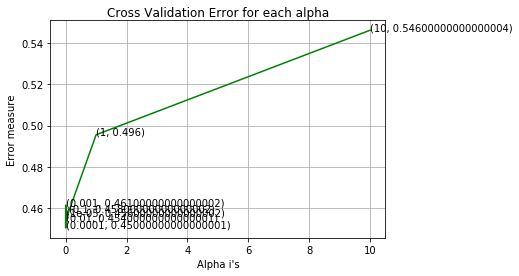

In [27]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_data, y_train)
    predict_y = sig_clf.predict_proba(test_data)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [28]:
best_alpha = np.argmin(log_error_array)

In [29]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_data, y_train)
sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(train_data, y_train)

predict_y = sig_clf.predict_proba(train_data)

print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_data)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
C = confusion_matrix(y_test, predicted_y)
A =(((C.T)/(C.sum(axis=1))).T)
B =(C/C.sum(axis=0))
print('Confusion Matrix')
print(C)
print('\n\nPrecision')
print(B)
print('\n\nRecall')
print(A)

For values of best alpha =  0.0001 The train log loss is: 0.454954506432
For values of best alpha =  0.0001 The test log loss is: 0.450363724367
Total number of data points : 15000
Confusion Matrix
[[8382 1023]
 [2433 3162]]


Precision
[[ 0.77503467  0.24444444]
 [ 0.22496533  0.75555556]]


Recall
[[ 0.89122807  0.10877193]
 [ 0.43485255  0.56514745]]


<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.464243617821
For values of alpha =  0.0001 The log loss is: 0.476613022085
For values of alpha =  0.001 The log loss is: 0.489650186544
For values of alpha =  0.01 The log loss is: 0.483986487766
For values of alpha =  0.1 The log loss is: 0.503113643508
For values of alpha =  1 The log loss is: 0.573368445062
For values of alpha =  10 The log loss is: 0.653244567668


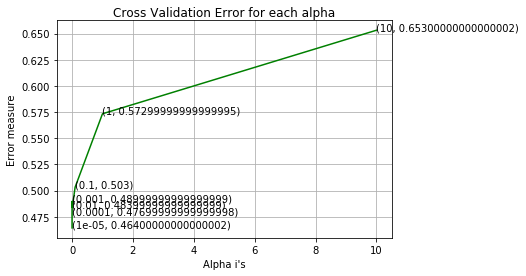

For values of best alpha =  1e-05 The train log loss is: 0.47109614723
For values of best alpha =  1e-05 The test log loss is: 0.464243617821
Total number of data points : 15000
Confusion Matrix
[[8747  658]
 [2775 2820]]


Precision
[[ 0.7591564   0.18918919]
 [ 0.2408436   0.81081081]]


Recall
[[ 0.93003721  0.06996279]
 [ 0.49597855  0.50402145]]


In [30]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(train_data, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_data, y_train)
    predict_y = sig_clf.predict_proba(test_data)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(train_data, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_data, y_train)

predict_y = sig_clf.predict_proba(train_data)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_data)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
C = confusion_matrix(y_test, predicted_y)
A =(((C.T)/(C.sum(axis=1))).T)
B =(C/C.sum(axis=0))
print('Confusion Matrix')
print(C)
print('\n\nPrecision')
print(B)
print('\n\nRecall')
print(A)

<h2> 4.6 XGBoost with hyperparameter tuning</h2>

In [33]:
params = {
'max_depth': [3, 4, 5, 6, 7, 8],
'eta' : [0.01, 0.02, 0.05, 0.1, 0.2, 0.3],
'n_estimators' : [100, 200, 300, 400, 500],
'gamma': [0, 0.5, 1, 1.5, 2, 5],
'objective' : ['binary:logistic']
}

In [43]:
from xgboost import XGBClassifier
folds=3
param_combined=4
xgb=XGBClassifier(nthreads=1)

In [45]:
from sklearn.model_selection import RandomizedSearchCV
skf=StratifiedKFold(n_splits=folds,shuffle=True,random_state=42)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='neg_log_loss', n_jobs=4, cv=skf.split(train_data,y_train), verbose=2, random_state=42 )
random_search.fit(train_data, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  3.6min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f064ce30678>,
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, nthreads=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=4, n_jobs=4,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500], 'gamma': [0, 0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5, 6, 7, 8], 'eta': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], 'objective': ['binary:logistic']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verbose=2)

In [48]:
best_parameters=random_search.best_params_

In [49]:
import xgboost as xgb


d_train = xgb.DMatrix(train_data, label=y_train)
d_test = xgb.DMatrix(test_data, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(best_parameters, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(train_data,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-error:0.195457	valid-error:0.1992
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 20 rounds.
[10]	train-error:0.158429	valid-error:0.176667
[20]	train-error:0.146571	valid-error:0.170467
[30]	train-error:0.131114	valid-error:0.1682
[40]	train-error:0.123657	valid-error:0.167467
[50]	train-error:0.115286	valid-error:0.164533
[60]	train-error:0.110314	valid-error:0.164067
[70]	train-error:0.104514	valid-error:0.163467
[80]	train-error:0.101343	valid-error:0.162867
[90]	train-error:0.097057	valid-error:0.161533
[100]	train-error:0.092857	valid-error:0.161
[110]	train-error:0.089571	valid-error:0.160533
[120]	train-error:0.084714	valid-error:0.1612
Stopping. Best iteration:
[103]	train-error:0.091571	valid-error:0.1602

The test log loss is: 0.332101433166


In [50]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
C = confusion_matrix(y_test, predicted_y)
A =(((C.T)/(C.sum(axis=1))).T)
B =(C/C.sum(axis=0))
print('Confusion Matrix')
print(C)
print('\n\nPrecision')
print(B)
print('\n\nRecall')
print(A)

Total number of data points : 15000
Confusion Matrix
[[8345 1060]
 [1354 4241]]


Precision
[[ 0.86039798  0.19996227]
 [ 0.13960202  0.80003773]]


Recall
[[ 0.88729399  0.11270601]
 [ 0.24200179  0.75799821]]


# Conclusion

In [53]:
from prettytable import PrettyTable
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Train log loss", "Test log loss"]
x.add_row(["TFIDF","Random Model", "-----", 0.881719781613])
x.add_row(["TFIDF","Logistic Regression", 0.454954506432, 0.450363724367])
x.add_row(["TFIDF","Linear SVM", 0.47109614723, 0.464243617821])
x.add_row(["TFIDF","XGBoost", 0.091571, 0.332101433166])
print(x)

+------------+---------------------+----------------+----------------+
| Vectorizer |        Model        | Train log loss | Test log loss  |
+------------+---------------------+----------------+----------------+
|   TFIDF    |     Random Model    |     -----      | 0.881719781613 |
|   TFIDF    | Logistic Regression | 0.454954506432 | 0.450363724367 |
|   TFIDF    |      Linear SVM     | 0.47109614723  | 0.464243617821 |
|   TFIDF    |       XGBoost       |    0.091571    | 0.332101433166 |
+------------+---------------------+----------------+----------------+


##### XGBoost is the best model.

# Steps Followed:

##  1. Understanding the Problem

Where else but Quora can a physicist help a chef with a math problem and get cooking tips in return? Quora is a place to gain and share knowledge about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Currently, Quora uses a Random Forest model to identify duplicate questions. In this case study, we have to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

## 2. Understanding the Dataset

- file: train.csv
- Contains 5 columns : qid1(question id 1), qid2(question id 2), question1, question2, is_duplicate 
- Size of the Dataset - 60MB 
- Number of rows/data points in the Dataset = 404,290

## 3. Lets us understand the Data better

- Visualise the Distribution of data points among output classes. We come to know that 63.08% Question pairs are not Similar (is_duplicate = 0) and the remaining 36.92% Question pairs are Similar (is_duplicate = 1)
- Nearly 66.52% of the total questions are unique.
- The maximum number of times a single question is repeated is 157
- Understand whether there is any missing data in the given dataset. Access them accordingly.

## 4. Basic Feature Extraction/Engineering & Visual Analysis

- freq_qid1 = Frequency of qid1's
- freq_qid2 = Frequency of qid2's
- q1len = Length of q1
- q2len = Length of q2
- q1_n_words = Number of words in Question 1
- q2_n_words = Number of words in Question 2
- word_Common = (Number of common unique words in Question 1 and Question 2)
- word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
- word_share = (word_common)/(word_Total)
- freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
- freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

<-> Add these features to the data in train.csv and save to df_fe_without_preprocessing_train.csv

## 5. Cleaning of the Dataset 

- Remove HTML Tags
- Removing Punctuations
- Performing stemming
- Expanding contractions

## 6. Advanced Feature Engineering (NLP and Fuzzy Features)

- cwc_min
- cwc_max
- csc_min
- csc_max
- ctc_min
- ctc_max
- last_word_eq
- first_word_eq 
- abs_len_diff
- mean_len
- fuzz_ratio
- fuzz_partial_ratio
- token_sort_ratio
- token_set_ratio
- longest_substr_ratio

<-> Read data from df_fe_without_preprocessing_train.csv and add these features and save to nlp_features_train.csv

## 7. Final Dataset Preparation
- Get required features from  df_fe_without_preprocessing_train.csv and nlp_features_train.csv and write to a dataframe with questions also.

## 8. Train-Test Split

- 70:30 Split was considered

## 9. Vectorization of the Questions using TFIDF(Term Frequency Inverse Document Frequency : with minimum df = 10)

- Vectorize the questions with maximum to 10k features.

## 10. Prepare the Train and Test Dataset

### 10(a). Train
- Use scipy.sparse.hstack to combine the TFIDF Vectorised Questions1, Questions2, Basic Engineered Features & Advanced Engineered Features

### 10(b). Test 
- Use scipy.hstack to combine the TFIDF Vectorised Questions1, Questions2, Basic Engineered Features & Advanced Engineered Features

## 11. Build a Random Model to estimate the Maximum Loss a Model can have (Worst Case)
- This helps us set a Standard to estimate how well our model performs.
- Plot the Confusion matrix, Precision matrix, Recall matrix.
- It gives us worst case log-loss.

## 12. Build a Logistic Regression Model with Hyperparameter Tuning
- Set a range of values for alpha ranging from 10^-5 to 10^2.
- Pick the best performing parameter on Train Data based on Loss .
- Consider Log loss and L2 penalty.
- Calculate the Loss with the obtained parameter on Test Data.
- Plot the Confusion matrix, Precision matrix, Recall matrix.

## 13. Build a Linear SVM Model with Hyperparameter Tuning
- Set a range of values for alpha ranging from 10^-5 to 10^2
- Pick the best performing parameter on Train Data based on Loss.
- Consider Hinge Loss and L1 penalty.
- Calculate the Loss with the obtained parameter on Test Data.
- Plot the Confusion matrix, Precision matrix, Recall matrix.

## 14. Build a XGBoost Model with Hyperparameter Tuning
- Set a range of values for a set of parameters.
- Apply RandomizedSearchCV.
- Use 3 fold Cross Vaidation.
- Pick the best performing parameter on Train Data based on Loss using random.best_params_
- Calculate the Loss with the obtained parameter on Test Data.
- Plot the Confusion matrix, Precision matrix, Recall matrix.